In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pandas as pd
import cv2
import torch.optim as optim
from helpers import Helpers

**Data preparation!**

In [ ]:
zip_path = '/content/WARWICK.zip'
extract_path = '/content/'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
extract_path = '/content/WARWICK'

train_path = os.path.join(extract_path, 'Train')
test_path = os.path.join(extract_path, 'Test')

print(train_path)
print(test_path)
print(f'train-path {train_path}')
image_files = sorted([f for f in os.listdir(train_path) if f.startswith('image_')])
print(image_files[0:10])
label_files = sorted([f for f in os.listdir(train_path) if f.startswith('label_')])
print(label_files[0:10])
print(f'test-path {test_path}')
image_files = sorted([f for f in os.listdir(test_path) if f.startswith('image_')])
print(image_files[0:10])
label_files = sorted([f for f in os.listdir(test_path) if f.startswith('label_')])
print(label_files[0:10])

/content/WARWICK/Train
/content/WARWICK/Test
train-path /content/WARWICK/Train
['image_01.png', 'image_02.png', 'image_03.png', 'image_04.png', 'image_05.png', 'image_06.png', 'image_07.png', 'image_08.png', 'image_09.png', 'image_10.png']
['label_01.png', 'label_02.png', 'label_03.png', 'label_04.png', 'label_05.png', 'label_06.png', 'label_07.png', 'label_08.png', 'label_09.png', 'label_10.png']
test-path /content/WARWICK/Test
['image_01.png', 'image_02.png', 'image_03.png', 'image_04.png', 'image_05.png', 'image_06.png', 'image_07.png', 'image_08.png', 'image_09.png', 'image_10.png']
['label_01.png', 'label_02.png', 'label_03.png', 'label_04.png', 'label_05.png', 'label_06.png', 'label_07.png', 'label_08.png', 'label_09.png', 'label_10.png']


*The dataset (WARWICK.zip) is provided with the task, including ground truth annotations by expert pathologists.
To reach improved performance, the stains have been unmixed resulting in two-channel images **(the blue component
in all the images is constant equal to zero)**. Your task is to, given an input image, compute an output label-image
which has the value one (1) where there is a gland in the image, and zero (0) otherwise.*

In [ ]:
class WarwickDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.startswith('image_')])
        self.label_files = sorted([f for f in os.listdir(label_dir) if f.startswith('label_')])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")

        if self.transform:
            image = self.transform(image)
            image = image[0:2,:,:]
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

max: 0.8588235378265381
mean: 0.13629134833197062
min: 0.0
shape: (128, 128, 3)
max: 0.9215686321258545
mean: 0.2931951063921379
min: 0.0
shape: (128, 128, 3)
max: 0.8666666746139526
mean: 0.18137015982647617
min: 0.0
shape: (128, 128, 3)
max: 0.9058823585510254
mean: 0.12072961675026288
min: 0.0
shape: (128, 128, 3)
max: 0.843137264251709
mean: 0.21141884629698401
min: 0.0
shape: (128, 128, 3)


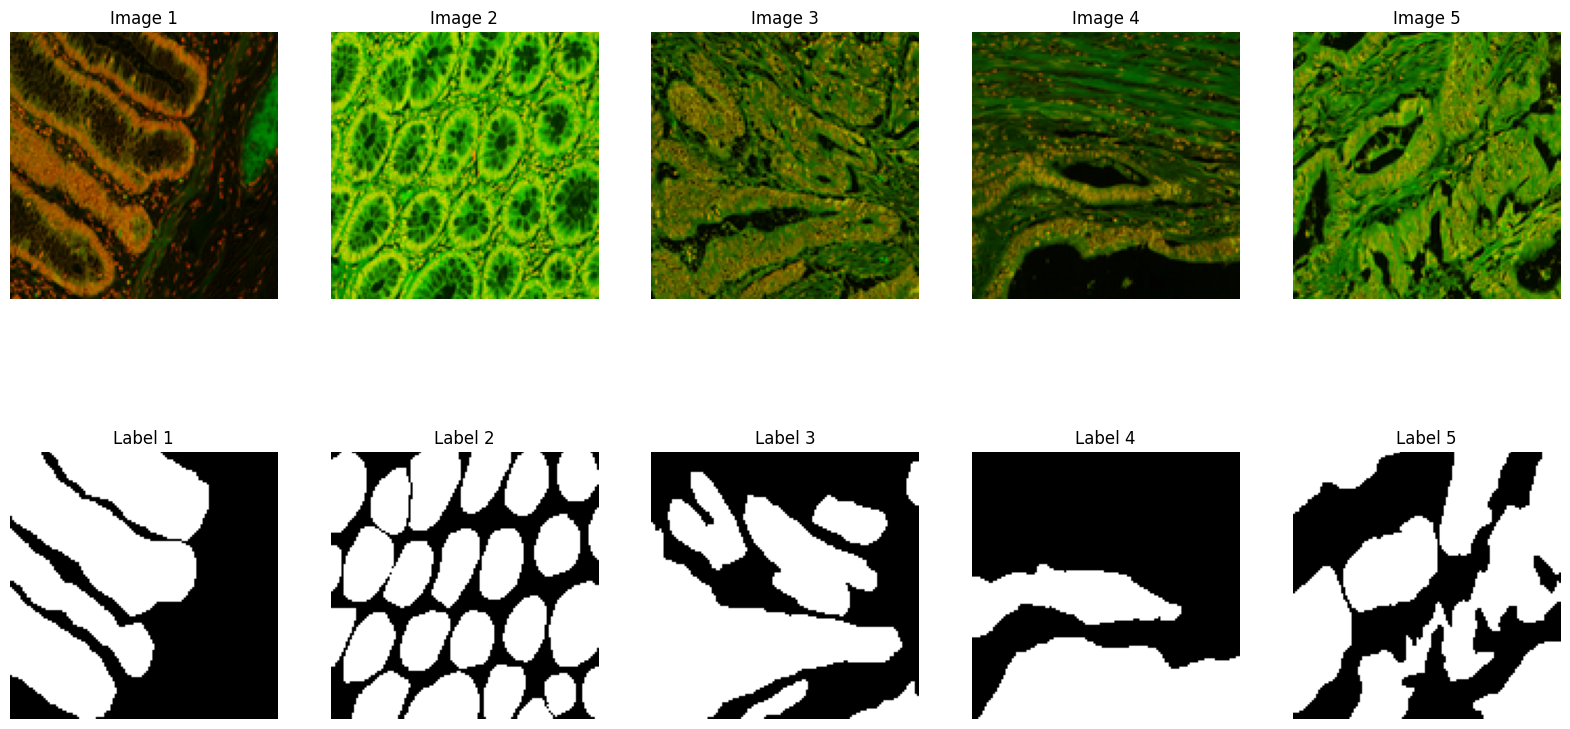

In [ ]:
import matplotlib.pyplot as plt
'''
def compute_mean_std(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, 3, -1)  # assuming 3-channel images

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std
'''

image_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

label_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = WarwickDataset(
    image_dir=os.path.join(extract_path, 'Train'),
    label_dir=os.path.join(extract_path, 'Train'),
    transform=image_transform,
    target_transform=label_transform
)

test_dataset = WarwickDataset(
    image_dir=os.path.join(extract_path, 'Test'),
    label_dir=os.path.join(extract_path, 'Test'),
    transform=image_transform,
    target_transform=label_transform
)

# checking to see if it works

batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_iter = iter(train_loader)
val_iter = iter(val_loader)
images, labels = next(train_iter)

f, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    img = images[i].permute(1, 2, 0)  # [2, H, W] -> [H, W, 2]
    h, w, _ = img.shape
    blue_channel = np.zeros((h,w,1))
    img = np.concatenate((img, blue_channel), axis=2)
    lbl = labels[i].squeeze()         # [1, H, W] -> [H, W]

    axs[0, i].imshow(img)
    axs[0, i].set_title(f"Image {i+1}")
    axs[0, i].axis('off')

    axs[1, i].imshow(lbl, cmap='gray')
    axs[1, i].set_title(f"Label {i+1}")
    axs[1, i].axis('off')
    print(f'max: {img.max()}')
    print(f'mean: {img.mean()}')
    print(f'min: {img.min()}')
    print(f'shape: {img.shape}')

**Exercise 1.1:** *Semantic Segmentation*
For this task, a relatively simple network is employed. It performs convolution operations along with pooling to progressively reduce the spatial dimensions of the input (encoding). Once the spatial resolution has been sufficiently reduced, the representation is upsampled using transposed convolution operations (decoding) to restore the original input size. The final output is produced through a 1$\times$1 convolution for binary classification at the pixel level.

In order to measure the correctness of the model, binary cross-entropy with logits (**BCEWithLogitsLoss**) is applied as the primary loss function. This loss quantifies the difference between the predicted logits and the ground truth labels on a pixel-wise basis, making it well-suited for binary segmentation tasks.

Meanwhile, Dice Score is used as a complementary metric to capture the overlap between predicted and true segmentation masks. Unlike BCE, Dice Score is sensitive to class imbalance and provides a more intuitive measure of segmentation quality, especially when the foreground class occupies a small portion of the image. It ranges from 0 (no overlap) to 1 (perfect overlap), with higher values indicating better performance in terms of correctly segmenting the foreground class.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncDecSegmentation(nn.Module):
    def __init__(self):
        super(EncDecSegmentation, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),  # 128x128 to 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),  # 64x64 to 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),  # 32x32 to 16x16
            nn.ReLU()
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 to 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 to 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 64x64 to 128x128
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1),  # classification
        )
        self.initialize_weights()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [ ]:
# seed
torch.manual_seed(26)
torch.cuda.manual_seed_all(26)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(26)

model = EncDecSegmentation()
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params}")

EncDecSegmentation(
  (encoder): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)
Trainable parameters: 265121


**Dice-Score**
Dice score is a measurement of similarity between two sets, ranging from 0 to 1.
$$
\text{DSC}= \frac{2\cdot|Y\cap \hat{Y}|}{|Y|+|\hat{Y}|},
$$
where $Y$ is *ground truth* positive pixels, $\hat{Y}$ is the *predicted* positive pixels, $̣|Y\cap \hat{Y}|$ is the pixels correctly predicted as positive.

Basically computing the ratio of true positives to the total number of positive pixels.
$$
\text{DSC}=\frac{2\cdot\text{True Positives}}{2\cdot\text{TP}+\text{FP}+\text{FN}}
$$
Dice loss does not take in to account true negatives and does trea

**Hyperparameter optimization**
Optuna differs from just performing a normal grid-search by employing Bayesian optimization with a Tree-structured Parzen Estimator. Optuna dynamically selects the next set of hyperparameters to evaluate based on past performance, allowing for pruning and focusing on promising regions.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import optuna

def objective(trial):
    # params to iterate between
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-2)
    batch_size = trial.suggest_int('batch_size', 8, 32, step=8)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-8, 1e-4)

    model = EncDecSegmentation()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    best_val_dice = 0.0

    for epoch in range(15):
        model.train()

        train_loss = 0.0
        train_tp, train_fp, train_fn = 0.0, 0.0, 0.0  # tp, fp, fn

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float() # binarize
            train_tp += ((preds == 1) & (labels == 1)).sum().item()
            train_fp += ((preds == 1) & (labels == 0)).sum().item()
            train_fn += ((preds == 0) & (labels == 1)).sum().item()

        train_dice = (2. * train_tp) / (2. * train_tp + train_fp + train_fn + 1e-6)
        avg_train_loss = train_loss / len(train_loader)

        # evaluation
        model.eval()
        val_tp, val_fp, val_fn = 0.0, 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                preds = (torch.sigmoid(outputs) > 0.5).float() # binarize
                val_tp += ((preds == 1) & (labels == 1)).sum().item()
                val_fp += ((preds == 1) & (labels == 0)).sum().item()
                val_fn += ((preds == 0) & (labels == 1)).sum().item()

        val_dice = (2. * val_tp) / (2. * val_tp + val_fp + val_fn + 1e-6) #1e-6 no division by zeor
        best_val_dice = max(best_val_dice, val_dice) # storing best dice score

        trial.report(val_dice, epoch) # optuna quits the trial if not worth continuing
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_dice

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=26))
study.optimize(objective, n_trials=150)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best validation Dice: {study.best_value}")


[I 2025-04-17 23:02:59,347] A new study created in memory with name: no-name-41cae635-3011-4334-b50b-875e04594884
<ipython-input-74-471434868f13>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-6, 1e-2)
<ipython-input-74-471434868f13>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-8, 1e-4)
[I 2025-04-17 23:03:04,665] Trial 0 finished with value: 0.5460647063503028 and parameters: {'lr': 1.705060566724795e-05, 'batch_size': 24, 'weight_decay': 1.1835610001135786e-05}. Best is trial 0 with value: 0.5460647063503028.
[I 2025-04-17 23:03:09,153] Trial 1 finished with value:

Best hyperparameters: {'lr': 0.0017033906042401516, 'batch_size': 8, 'weight_decay': 1.089958844961946e-07}
Best validation Dice: 0.8047940989732285


were doing mini-batch GD so i wont achieve the exact same performance every time but this might serve as a good pointer

In [ ]:
from torch.optim import lr_scheduler

model = EncDecSegmentation()
lr = 0.0017033906042401516
batch_size = 8
EPOCHS = 45

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1.089958844961946e-07)
scheduler = None
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_costs, test_costs, train_dices, test_dices, training_time = Helpers.training_loop(model, train_loader, val_loader, optimizer, scheduler, criterion, device, EPOCHS)

Epoch 1/45 - Train Loss: 0.6953, Train Dice: 0.5910
Epoch 1/45 - Validation Loss: 0.6933, Validation Dice: 0.0147
Epoch 2/45 - Train Loss: 0.6935, Train Dice: 0.0007
Epoch 2/45 - Validation Loss: 0.6934, Validation Dice: 0.0000
Epoch 3/45 - Train Loss: 0.6932, Train Dice: 0.0000
Epoch 3/45 - Validation Loss: 0.6928, Validation Dice: 0.0000
Epoch 4/45 - Train Loss: 0.6908, Train Dice: 0.0012
Epoch 4/45 - Validation Loss: 0.6869, Validation Dice: 0.0405
Epoch 5/45 - Train Loss: 0.6719, Train Dice: 0.3746
Epoch 5/45 - Validation Loss: 0.6624, Validation Dice: 0.5947
Epoch 6/45 - Train Loss: 0.8174, Train Dice: 0.5598
Epoch 6/45 - Validation Loss: 0.7000, Validation Dice: 0.4544
Epoch 7/45 - Train Loss: 0.5770, Train Dice: 0.7233
Epoch 7/45 - Validation Loss: 0.6096, Validation Dice: 0.5875
Epoch 8/45 - Train Loss: 0.5669, Train Dice: 0.7154
Epoch 8/45 - Validation Loss: 0.6741, Validation Dice: 0.6939
Epoch 9/45 - Train Loss: 0.6194, Train Dice: 0.6857
Epoch 9/45 - Validation Loss: 0.6972

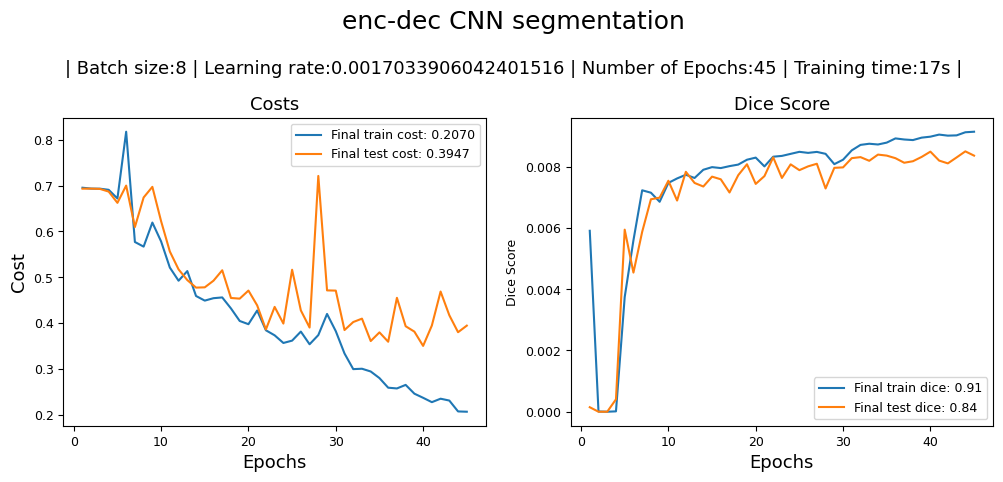

In [ ]:
Helpers.training_curve_plot('enc-dec CNN segmentation', train_costs, test_costs, train_dices, test_dices, batch_size, lr, EPOCHS, training_time)

In [ ]:
import importlib
import helpers

importlib.reload(helpers)
from helpers import Helpers

In [ ]:
Helpers.visualize_predictions(model, val_loader, device, batch_size)

In [ ]:
Helpers.imshowpair(model, val_loader, device, batch_size)

**Exercise 1.2:** *Skip-connections*
For this part of the assignment we are tasked to implement skip-connections, similar to the U-net paper. These skip connections bring higher resolution information into the upsampling path.

The new architecture is to be compared with the earlier, more naive approach.

In the U-Net paper each SC seems to be applied before every downsampling of the image. So we split our encoder-decoder blocks up into smaller sub-blocks enabling for skip-connections across blocks. I also notice that in the paper they seem to use He initialization which we incorporated in *1.1*. So we stick with that init.

In the U-Net paper when concatenating the feature maps from the encoder-block they apply more convolution operations to process the merged features. When performing the skip-connections the number of channels are doubled, these convs reduce the number of channels and merge features (*dec$_n$*) convs.

In the real U-net they also seem to perform double convolutions:
(Conv $→$ ReLu $→$ Conv $→$ Relu $→$ pool)

Where, in this network only one convolution is performed - this network is therefore not as complex as the U-Net paper network. As the model is already overfitting to our data, creating a much more complex model might not be beneficial in this case.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderDecoderSCNetwork(nn.Module):
    def __init__(self):
        super(EncoderDecoderSCNetwork, self).__init__()
        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2) # 64x64

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2) # 32x32

        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2) # 16x16

        # decoder
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 to 32x32
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 to 64x64
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 64x64 to 128x128
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(32 + 16, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.out = nn.Conv2d(16, 1, kernel_size=1)  # classification, 128x128x1
        self.initialize_weights()

    def forward(self, x):
        # encoding
        x128 = self.enc1(x)
        x = self.pool1(x128)
        x64 = self.enc2(x)
        x = self.pool2(x64)
        x32 = self.enc3(x)
        x = self.pool3(x32)

        # decoding
        x = self.up1(x)              # 32x32
        x = torch.cat([x, x32], dim=1)  # skip-connection
        x = self.dec1(x)

        x = self.up2(x)              # 64x64
        x = torch.cat([x, x64], dim=1)
        x = self.dec2(x)

        x = self.up3(x)              # 128x128
        x = torch.cat([x, x128], dim=1)
        x = self.dec3(x)

        out = self.out(x)            # final conv layer
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [ ]:
model = EncoderDecoderSCNetwork()
print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params}")

EncoderDecoderSCNetwork(
  (enc1): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (dec1): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (up2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
 

Finding parameters!

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import optuna

def objective(trial):
    # params to iterate between
    lr = trial.suggest_loguniform('lr', 1e-7, 1e-3)
    batch_size = trial.suggest_int('batch_size', 8, 32, step=8)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-8, 1e-4)

    model = EncoderDecoderSCNetwork()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    best_val_dice = 0.0

    for epoch in range(45):
        model.train()

        train_loss = 0.0
        train_tp, train_fp, train_fn = 0.0, 0.0, 0.0  # tp, fp, fn

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float() # binarize
            train_tp += ((preds == 1) & (labels == 1)).sum().item()
            train_fp += ((preds == 1) & (labels == 0)).sum().item()
            train_fn += ((preds == 0) & (labels == 1)).sum().item()

        train_dice = (2. * train_tp) / (2. * train_tp + train_fp + train_fn + 1e-6)
        avg_train_loss = train_loss / len(train_loader)

        # evaluation
        model.eval()
        val_tp, val_fp, val_fn = 0.0, 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                preds = (torch.sigmoid(outputs) > 0.5).float() # binarize
                val_tp += ((preds == 1) & (labels == 1)).sum().item()
                val_fp += ((preds == 1) & (labels == 0)).sum().item()
                val_fn += ((preds == 0) & (labels == 1)).sum().item()

        val_dice = (2. * val_tp) / (2. * val_tp + val_fp + val_fn + 1e-6) #1e-6 no division by zeor
        best_val_dice = max(best_val_dice, val_dice) # storing best dice score

        trial.report(val_dice, epoch) # optuna quits the trial if not worth continuing
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_dice

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=26))
study.optimize(objective, n_trials=150)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best validation Dice: {study.best_value}")


[I 2025-04-21 13:59:45,744] A new study created in memory with name: no-name-767fff76-823c-4147-87d2-e10accced018
<ipython-input-41-a5ac027762ae>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-7, 1e-3)
<ipython-input-41-a5ac027762ae>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-8, 1e-4)
[I 2025-04-21 14:00:08,703] Trial 0 finished with value: 0.06221978649832534 and parameters: {'lr': 1.7050605667247933e-06, 'batch_size': 24, 'weight_decay': 1.1835610001135786e-05}. Best is trial 0 with value: 0.06221978649832534.
[I 2025-04-21 14:00:26,135] Trial 1 finished with val

Best hyperparameters: {'lr': 0.0009617430371846932, 'batch_size': 8, 'weight_decay': 1.7141421969243176e-07}
Best validation Dice: 0.8632391617053928


In [ ]:
from torch.optim import lr_scheduler

model = EncoderDecoderSCNetwork()
lr = 0.0009617430371846932
batch_size = 8
EPOCHS = 60

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1.7141421969243176e-07)
scheduler = None
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_costs, test_costs, train_dices, test_dices, training_time = Helpers.training_loop(model, train_loader, val_loader, optimizer, scheduler, criterion, device, EPOCHS)

Epoch 1/60 - Train Loss: 0.6773, Train Dice: 0.6625
Epoch 1/60 - Validation Loss: 0.6846, Validation Dice: 0.6195
Epoch 2/60 - Train Loss: 0.6360, Train Dice: 0.6499
Epoch 2/60 - Validation Loss: 0.6497, Validation Dice: 0.5100
Epoch 3/60 - Train Loss: 0.5995, Train Dice: 0.6449
Epoch 3/60 - Validation Loss: 0.6808, Validation Dice: 0.6057
Epoch 4/60 - Train Loss: 0.5638, Train Dice: 0.6765
Epoch 4/60 - Validation Loss: 0.6358, Validation Dice: 0.5449
Epoch 5/60 - Train Loss: 0.5417, Train Dice: 0.7031
Epoch 5/60 - Validation Loss: 0.5620, Validation Dice: 0.6276
Epoch 6/60 - Train Loss: 0.5187, Train Dice: 0.7147
Epoch 6/60 - Validation Loss: 0.6707, Validation Dice: 0.7006
Epoch 7/60 - Train Loss: 0.5797, Train Dice: 0.7131
Epoch 7/60 - Validation Loss: 0.5970, Validation Dice: 0.7302
Epoch 8/60 - Train Loss: 0.5179, Train Dice: 0.7188
Epoch 8/60 - Validation Loss: 0.5728, Validation Dice: 0.5988
Epoch 9/60 - Train Loss: 0.4851, Train Dice: 0.7529
Epoch 9/60 - Validation Loss: 0.5668

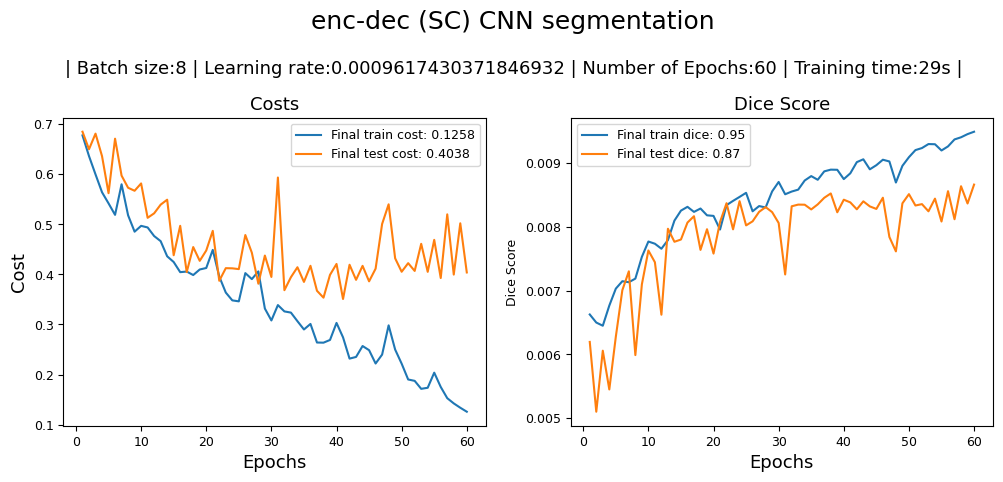

In [ ]:
Helpers.training_curve_plot('enc-dec (SC) CNN segmentation', train_costs, test_costs, train_dices, test_dices, batch_size, lr, EPOCHS, training_time)

In [ ]:
Helpers.visualize_predictions(model, val_loader, device, batch_size)
Helpers.imshowpair(model, val_loader, device, batch_size)

**Exercise 1.3. Residual connections**
In this part of the lab we are tasked to implement residual connections, like in the ResNet paper. We are then to evaluate this model

A module ResBlock consists of a convolution $→$ ReLU $→$ convolution
In order to handle channel-mismatch after the convolution another convolution operation projecting our x to correct shape. *The projection shortcut (p4)*. Another way to handle this would be zero-padding to add dimensions.

**Identity mapping**
$$\text{out}=\mathcal{F}(x)+x$$
**Projection shortcut**
$$\text{out}=\mathcal{F}(x)+\mathcal{W_s}x$$
$\mathcal{W_s} = 1\times1 \text{ conv}$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, c_in, c_out, batch_norm=True):
        super(ResBlock, self).__init__()
        self.batch_norm = batch_norm
        self.conv1 = nn.Conv2d(c_in, c_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(c_out, c_out, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

        if c_in != c_out:
            self.conv_skip = nn.Conv2d(c_in, c_out, kernel_size=1)
        else:
            self.conv_skip = nn.Identity()
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(c_out)
            self.bn2 = nn.BatchNorm2d(c_out)

    def forward(self, x):
        skip = self.conv_skip(x)
        out = self.conv1(x)
        if self.batch_norm:
            out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        if self.batch_norm:
            out = self.bn2(out)
        out += skip
        out = self.relu(out)
        return out


class EncDecResSegmentation(nn.Module):
    def __init__(self):
        super(EncDecResSegmentation, self).__init__()
        # enc
        self.res_1 = ResBlock(2, 32)
        self.pool_1 = nn.MaxPool2d(2, 2)  # 128x128 to 64x64
        #self.conv_1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        #self.pool_1 = nn.MaxPool2d(2, 2)  # 128x128 to 64x64
        self.res_2 = ResBlock(32, 64)
        self.pool_2 = nn.MaxPool2d(2, 2)  # 64x64 to 32x32
        self.res_3 = ResBlock(64, 128)
        self.pool_3 = nn.MaxPool2d(2, 2)  # 32x32 to 16x16

        # dec
        self.conv_tr_1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 16x16 to 32x32
        self.conv_tr_2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 32x32 to 64x64
        self.conv_tr_3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)  # 64x64 to 128x128
        self.conv_classify = nn.Conv2d(16, 1, kernel_size=1)  # classification

        self.nonlin = nn.ReLU()
        self.initialize_weights()

    def forward(self, x):
        # enc
        x = self.res_1(x)
        x = self.pool_1(x)
        x = self.res_2(x)
        x = self.pool_2(x)
        x = self.res_3(x)
        x = self.pool_3(x)


        # dec
        x = self.conv_tr_1(x)
        x = self.nonlin(x)
        x = self.conv_tr_2(x)
        x = self.nonlin(x)
        x = self.conv_tr_3(x)
        x = self.nonlin(x)
        x = self.conv_classify(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [ ]:
model = EncDecResSegmentation()
print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params}")

EncDecResSegmentation(
  (res_1): ResBlock(
    (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (conv_skip): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res_2): ResBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (conv_skip): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
!pip install optuna

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import optuna

def objective(trial):
    # params to iterate between
    lr = trial.suggest_loguniform('lr', 1e-7, 1e-3)
    batch_size = trial.suggest_int('batch_size', 8, 32, step=8)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-8, 1e-4)

    model = EncDecResSegmentation()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    best_val_dice = 0.0

    for epoch in range(45):
        model.train()

        train_loss = 0.0
        train_tp, train_fp, train_fn = 0.0, 0.0, 0.0  # tp, fp, fn

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float() # binarize
            train_tp += ((preds == 1) & (labels == 1)).sum().item()
            train_fp += ((preds == 1) & (labels == 0)).sum().item()
            train_fn += ((preds == 0) & (labels == 1)).sum().item()

        train_dice = (2. * train_tp) / (2. * train_tp + train_fp + train_fn + 1e-6)
        avg_train_loss = train_loss / len(train_loader)

        # evaluation
        model.eval()
        val_tp, val_fp, val_fn = 0.0, 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                preds = (torch.sigmoid(outputs) > 0.5).float() # binarize
                val_tp += ((preds == 1) & (labels == 1)).sum().item()
                val_fp += ((preds == 1) & (labels == 0)).sum().item()
                val_fn += ((preds == 0) & (labels == 1)).sum().item()

        val_dice = (2. * val_tp) / (2. * val_tp + val_fp + val_fn + 1e-6) #1e-6 no division by zeor
        best_val_dice = max(best_val_dice, val_dice) # storing best dice score

        trial.report(val_dice, epoch) # optuna quits the trial if not worth continuing
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_dice

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=26))
study.optimize(objective, n_trials=150)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best validation Dice: {study.best_value}")


Epoch 1/40 - Train Loss: 0.7019, Train Dice: 0.5946
Epoch 1/40 - Validation Loss: 0.6843, Validation Dice: 0.6590
Epoch 2/40 - Train Loss: 0.5943, Train Dice: 0.6876
Epoch 2/40 - Validation Loss: 0.8894, Validation Dice: 0.6335
Epoch 3/40 - Train Loss: 0.5199, Train Dice: 0.7516
Epoch 3/40 - Validation Loss: 0.7863, Validation Dice: 0.6631
Epoch 4/40 - Train Loss: 0.4541, Train Dice: 0.8005
Epoch 4/40 - Validation Loss: 0.6108, Validation Dice: 0.7079
Epoch 5/40 - Train Loss: 0.4160, Train Dice: 0.8130
Epoch 5/40 - Validation Loss: 0.6800, Validation Dice: 0.7093
Epoch 6/40 - Train Loss: 0.4113, Train Dice: 0.8187
Epoch 6/40 - Validation Loss: 0.6355, Validation Dice: 0.7430
Epoch 7/40 - Train Loss: 0.3827, Train Dice: 0.8302
Epoch 7/40 - Validation Loss: 0.4696, Validation Dice: 0.7461
Epoch 8/40 - Train Loss: 0.3438, Train Dice: 0.8531
Epoch 8/40 - Validation Loss: 0.3971, Validation Dice: 0.8021
Epoch 9/40 - Train Loss: 0.3373, Train Dice: 0.8591
Epoch 9/40 - Validation Loss: 0.5933

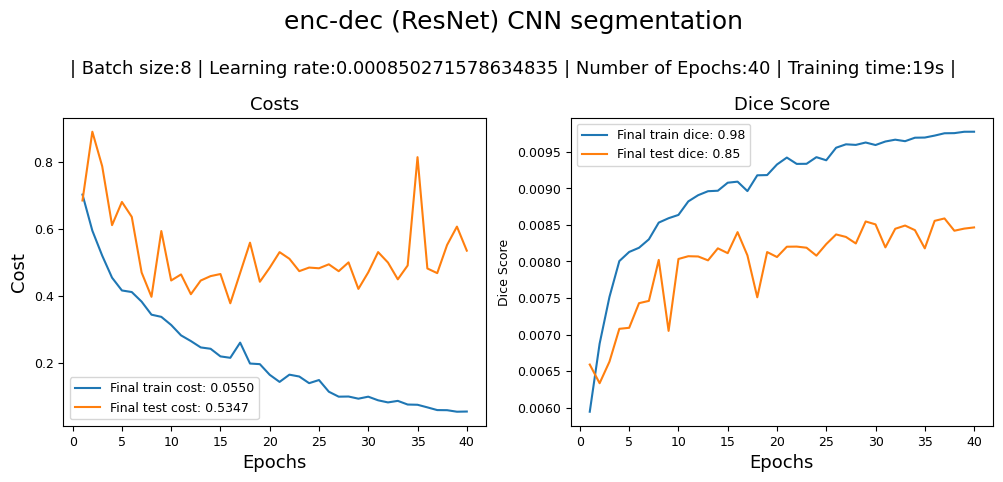

In [ ]:
from torch.optim import lr_scheduler

model = EncDecResSegmentation()
lr = 0.000850271578634835
batch_size = 8
EPOCHS = 40

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1.5517112509292895e-08)
scheduler = None
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_costs, test_costs, train_dices, test_dices, training_time = Helpers.training_loop(model, train_loader, val_loader, optimizer, scheduler, criterion, device, EPOCHS)

Helpers.training_curve_plot('enc-dec (ResNet) CNN segmentation', train_costs, test_costs, train_dices, test_dices, batch_size, lr, EPOCHS, training_time)

In [ ]:
Helpers.visualize_predictions(model, val_loader, device, batch_size)
Helpers.imshowpair(model, val_loader, device, batch_size)

**Exercise 1.4. Performance optimization, three variations**
Now try your best to maximize the performance. Evaluate on the same segmentation task, three different techniques
on how to improve the performance on unseen data. Finally, combine the best of the best. Here, you will probably
want to split the training data into training+validation when performing parameter tuning. Suggested is to make
your code deterministic, see. https://pytorch.org/docs/stable/notes/randomness.html, to reduce
fluctuations in your performance evaluation.
Complement in the report raw performance figures (learning curve plots) with your own subjective opinions
regarding the different techniques (e.g. regarding stability and speed of training, design complexity, hyper parameter
tuning sensitivity).

• What did did you change and why?

• Provide learning curve plots for losses and DICE score (instead of accuracy).

• Is the network overfitting or underfiting?

• Provide all hyperparameters to the optimizer, loss function, augmentation etc. (including default values of
your chosen framework) such that someone else can try to repeat your work (reproducible research).

• Visually inspect two of the cases (in the test-set), one where the network preformed well and one where the
network did not perform well in terms of dice score, and try to describe what you think makes that particular
instance challenging in comparison to the other instances. Include the examples as images of the network
output, ground truth mask and raw image in your report.

(a) First variation

(b) Second variation

(c) Third variation

(d) Best of the best